# CVAE-LSTM using information from the hidden states of the nHMM

In [6]:
import os
os.environ["R_HOME"] = r"/Library/Frameworks/R.framework/Versions/4.4-x86_64/Resources"  # Change this path according to your R installation.

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.dates as mdates

import seaborn as sns
import numpy as np
from rpy2.robjects import r, pandas2ri
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import IntVector

# Enable conversion between pandas and R
pandas2ri.activate()

# Load the R base package
base = importr('base')
# Load the package depmixS4
depmixS4 = importr("depmixS4")
# Set the seed in R for reproducibility
r('set.seed(2031)')
# Set seed in Python for reproducibility
np.random.seed(2031)

In [7]:
covid_data = pd.read_excel('/Users/mauricioherrera/mis_env/covid-nhmm/data/covid_data.xlsx')# cambiar la ruta

In [8]:
covid_data.rename(columns={'IM_interno': 'Internal_Mobility_Index',
                           'IM_externo': 'External_Mobility_Index',
                           'inc_pc_comuna': 'Per_Capita_Income',
                           'TasaCasosAcumulados': 'Cumulative_Cases_Rate',
                           'Personas_hogar_promedio': 'Average_Household_Persons',
                           'inmigrantes': 'Inmigrants',
                           'total_hog_hacinados': 'Total_Households_Housed',
                           'indic_precariedad_vivienda': 'Housing_Precariousness_Index',
                           'Comuna': 'Commune',
                           'fecha': 'Date',
                           'dias': 'Days',
                           'por_educ_sup': 'Higher_Education_Percentage',
                           'porc_postgrado': 'Postgraduade_Percentage',
                           'IPS_2020': 'Social_Priority_Index_2020',
                           'Prioridad_2020': 'Priority_2020',
                           'CODIGO':'Code',
                           'year': 'Year',
                           'month': 'Month',
                           'paso': 'Step',
                           'paso_etiqueta': 'Step_Label',
                           'Fecha inicio cuarentena': 'Quarantine_Start_Date',
                           'Fecha término cuarentena': 'Quarantine_End_Date',
                           'Casos_Diarios_Brutos': 'Gross_Daily_Cases',
                           'Casos_Diarios_Brutos_MM7': 'Gross_Daily_Cases_Mobile_Average_7_Days'}, inplace=True)

In [9]:
# Remove rows with null values in the relevant columns:
covid_data = covid_data.dropna(subset=['Gross_Daily_Cases', 'Gross_Daily_Cases_Mobile_Average_7_Days', 'Date'])
# Reset index and add row_id for merge:
covid_data = covid_data.reset_index(drop=True)
covid_data['row_id'] = covid_data.index  # for subsequent merge

In [10]:
reference_date = covid_data['Date'].min()  # Earliest date in your dataset

In [11]:
covid_data['Days'] = reference_date + pd.to_timedelta(covid_data['Days'], unit='D')

In [12]:
# Create `ntimes` from clean data
ntimes = IntVector(covid_data.groupby("Commune")["Days"].count().tolist())

# Validate consistency:
print(sum(ntimes))        # Total observations (must match len(covid_data))
print(len(covid_data))    # To check alignment

7276
7276


## Fitting the nHMM model with 6 hidden states and direct simulations with the obtained model

converged at iteration 64 with logLik: -17899.32 


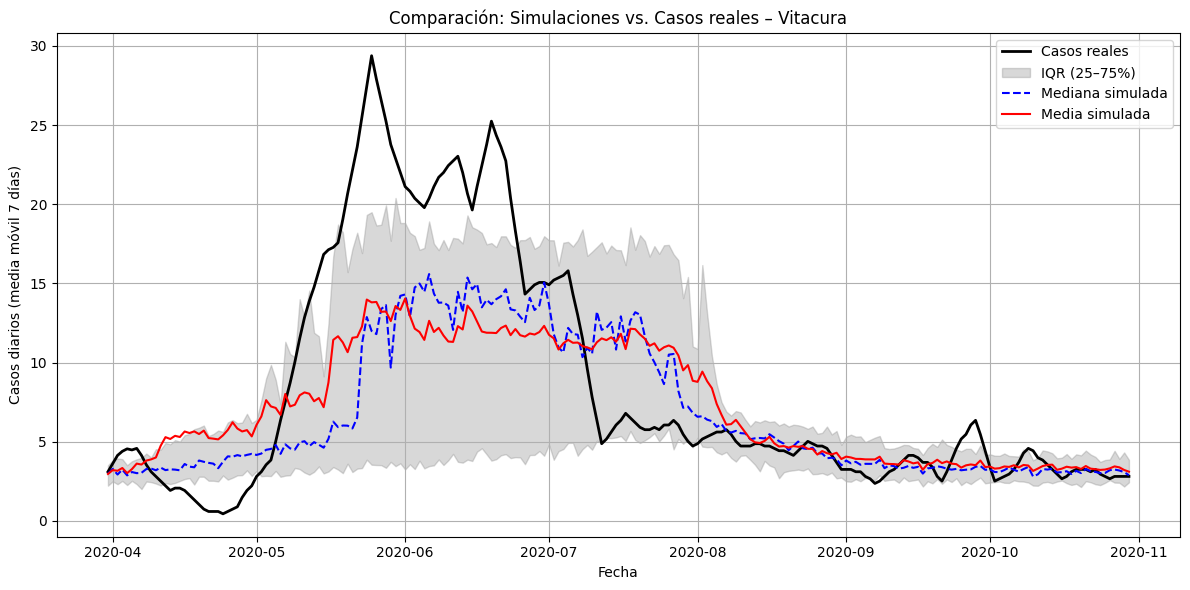

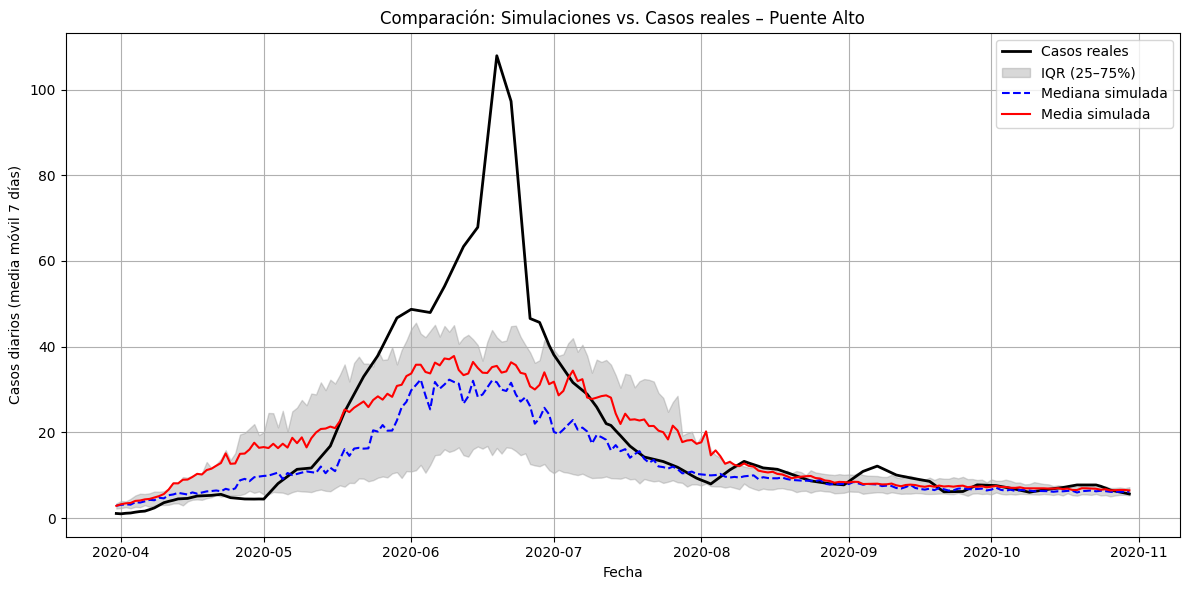

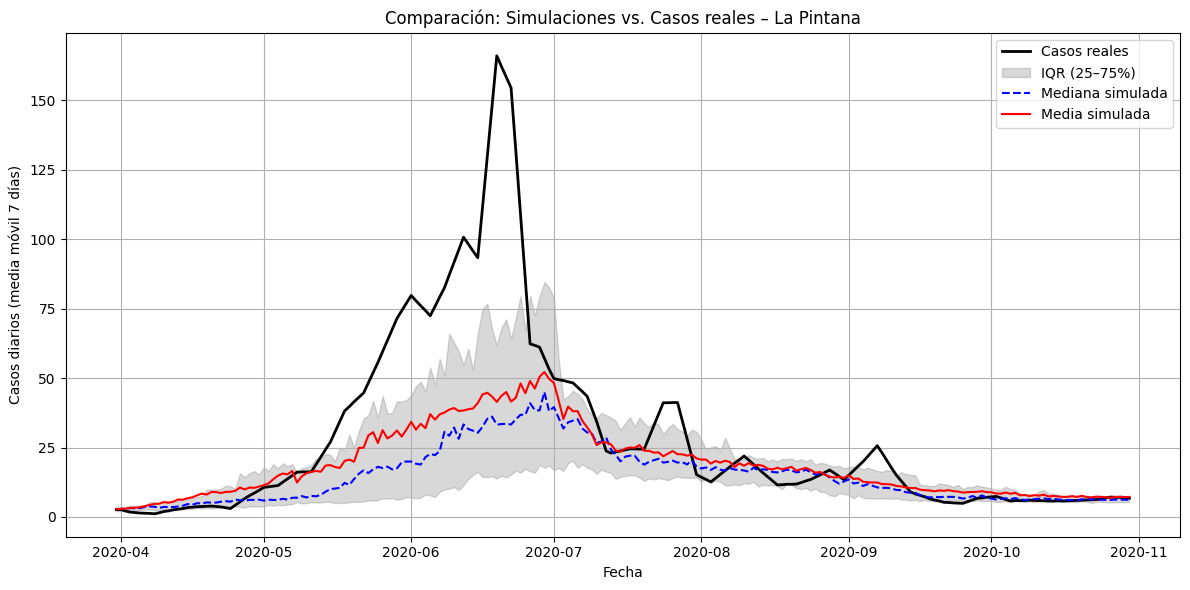

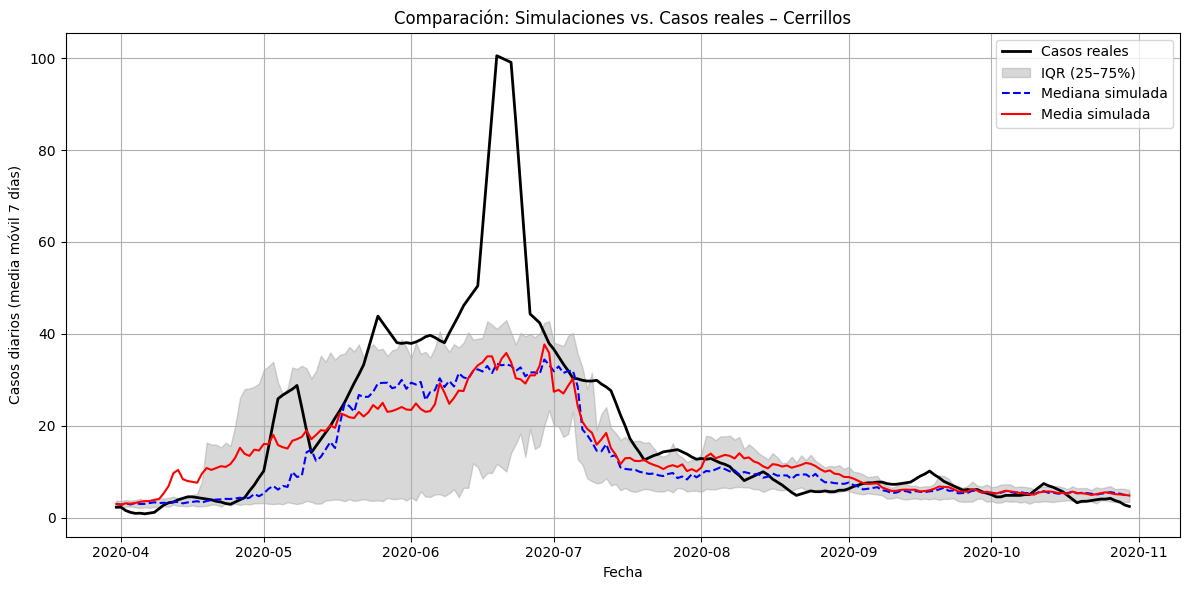

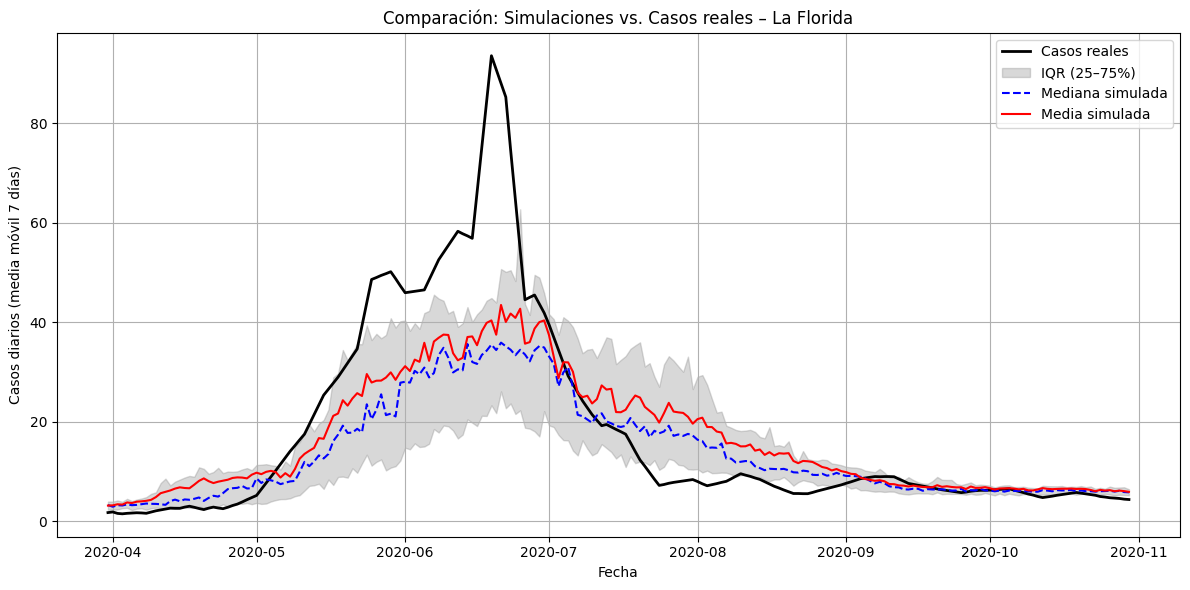

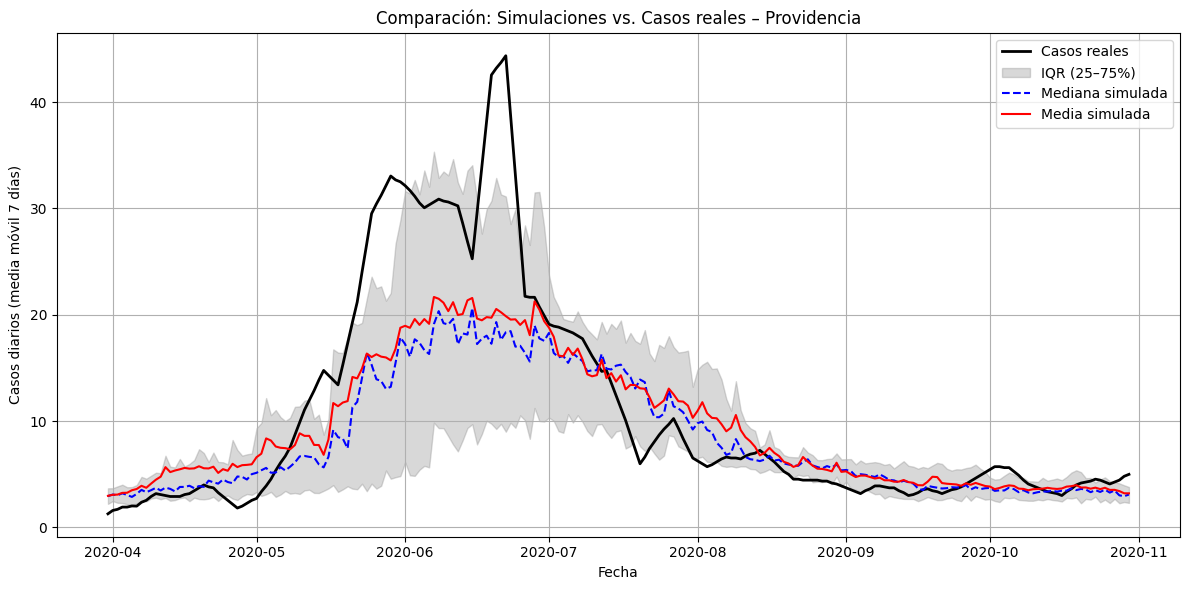

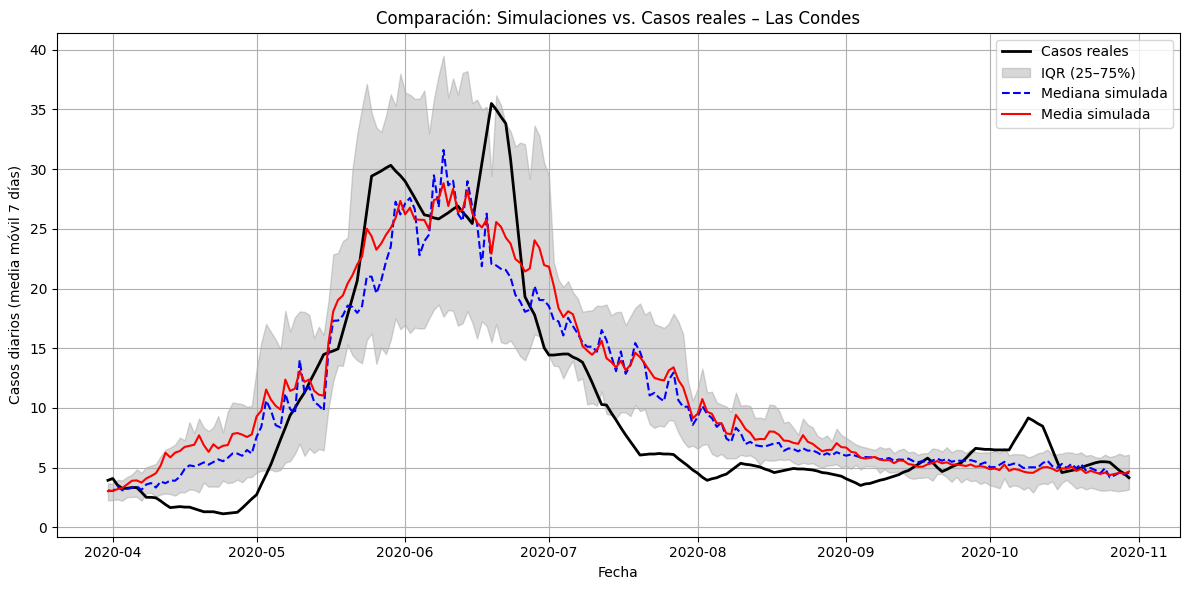

In [13]:
# Paso 1: Activar rpy2 y preparar datos en R
from rpy2.robjects import r, pandas2ri
from rpy2.robjects.packages import importr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Activar conversión automática
pandas2ri.activate()
r.assign("covid_data_r", pandas2ri.py2rpy(covid_data))
r.assign("ntimes", pandas2ri.py2rpy(ntimes))

# Paso 2: Ajustar HMM con fórmula en escala transformada
hmm_formula = r("as.formula")("Gross_Daily_Cases_Mobile_Average_7_Days ~ 1")
trans_formula = r("as.formula")("~ Internal_Mobility_Index + External_Mobility_Index + Commune")
gaussian_family = r["gaussian"]()
depmixS4 = importr("depmixS4")

hmm_model = depmixS4.depmix(
    response=hmm_formula,
    data=r["covid_data_r"],
    nstates=6,
    family=gaussian_family,
    transition=trans_formula,
    ntimes=r["ntimes"]
)
hmm_fitted = depmixS4.fit(hmm_model, verbose=False)
r.assign("hmm_fitted", hmm_fitted)
# Paso 3: Simular 
N_sim = 100
r(f'''
set.seed(1234)
simulaciones_list <- vector("list", {N_sim})
for (i in 1:{N_sim}) {{
  sim <- simulate(hmm_fitted)
  sim_vals <- sim@response[[1]][[1]]@y
  simulaciones_list[[i]] <- sim_vals  # Inversa de Box-Cox
}}
sim_df <- as.data.frame(do.call(cbind, simulaciones_list))
colnames(sim_df) <- paste0("sim_", 1:{N_sim})
sim_df$Commune <- covid_data_r$Commune
sim_df$Date <- as.character(covid_data_r$Date)
''')

# Paso 4: Convertir a pandas y arreglar fechas
sim_df = pandas2ri.rpy2py(r['sim_df'])
sim_df['Date'] = pd.to_datetime(sim_df['Date'])

# Paso 5: Graficar simulaciones vs. datos reales
target_communes = ["Vitacura", "Puente Alto", "La Pintana", "Cerrillos", "La Florida","Providencia", "Las Condes"]
for comuna in target_communes:
    plt.figure(figsize=(12, 6))
    
    df_real = covid_data[covid_data["Commune"] == comuna].sort_values("Date")
    plt.plot(df_real["Date"], df_real["Gross_Daily_Cases_Mobile_Average_7_Days"],
             label="Casos reales", linewidth=2, color="black")

    df_sim = sim_df[sim_df["Commune"] == comuna].sort_values("Date")
    sim_cols = [col for col in df_sim.columns if col.startswith("sim_")]
    sim_values = df_sim[sim_cols].values
    dates = df_sim["Date"].values

    p25 = np.percentile(sim_values, 25, axis=1)
    p50 = np.percentile(sim_values, 50, axis=1)
    p75 = np.percentile(sim_values, 75, axis=1)
    mean = sim_values.mean(axis=1)

    plt.fill_between(dates, p25, p75, color="gray", alpha=0.3, label="IQR (25–75%)")
    plt.plot(dates, p50, linestyle="--", color="blue", label="Mediana simulada")
    plt.plot(dates, mean, linestyle="-", color="red", label="Media simulada")

    plt.title(f"Comparación: Simulaciones vs. Casos reales – {comuna}")
    plt.xlabel("Fecha")
    plt.ylabel("Casos diarios (media móvil 7 días)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [14]:
# Extract the most probable sequence of states (Viterbi path and probabilities)
posterior_probs = r['slot'](hmm_fitted, "posterior")

# Convert posterior_probs to pandas DataFrame
viterbi_df = pandas2ri.rpy2py(posterior_probs).reset_index(drop=True)
viterbi_df['row_id'] = viterbi_df.index

In [15]:
viterbi_merged = pd.merge(viterbi_df, covid_data, on='row_id', how='inner')
print(viterbi_merged.head()) 

   state             S1             S2             S3        S4  \
0    4.0   0.000000e+00   0.000000e+00   0.000000e+00  1.000000   
1    4.0  3.218545e-148  2.318481e-157  1.264816e-156  0.999981   
2    4.0   5.536453e-12   4.969462e-20   1.171670e-18  0.999999   
3    4.0   1.738039e-13   1.498231e-18   4.945726e-21  0.999999   
4    4.0   1.137356e-13   4.878134e-16   1.098264e-18  1.000000   

              S5            S6  row_id  Internal_Mobility_Index  \
0   0.000000e+00  0.000000e+00       0                 1.970381   
1  9.679336e-159  1.903653e-05       1                 1.845790   
2   1.344310e-20  1.384668e-06       2                 1.678598   
3   5.921117e-23  6.558878e-07       3                 1.736766   
4   3.036691e-20  1.687976e-07       4                 1.331296   

   External_Mobility_Index  ...                Priority_2020   Code  Year  \
0                 7.804008  ...  Media Baja Prioridad Social  13102  2020   
1                 7.471452  ...  Media B

In [16]:
# Renombrar la columna 'state' a 'Hidden_State'
viterbi_merged = viterbi_merged.rename(columns={"state": "Hidden_State"})

# Guardar como CSV en la ubicación indicada
output_path = '/Users/mauricioherrera/mis_env/covid-nhmm/notebooks/covid_data_with_6_states.csv'
viterbi_merged.to_csv(output_path, index=False)

print(f"Archivo guardado exitosamente en:\n{output_path}")


Archivo guardado exitosamente en:
/Users/mauricioherrera/mis_env/covid-nhmm/notebooks/covid_data_with_6_states.csv


## Construction of the CVAE-LSTM using information from the Viterbi sequence of the nHMM.

In [17]:
# =========================
# 1. ENTRENAMIENTO CVAE-LSTM
# =========================
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from torch.utils.data import DataLoader, TensorDataset

# Ruta local
l = '/Users/mauricioherrera/mis_env/covid-nhmm/notebooks'
data_path = os.path.join(l, "covid_data_with_6_states.csv")
model_path = os.path.join(l, "cvae_lstm_model.pth")

# Cargar datos completos
covid_data = pd.read_csv(data_path, parse_dates=["Date"])

# Ranking por severidad y pesos asignados
ranking = covid_data.groupby("Hidden_State")["Gross_Daily_Cases_Mobile_Average_7_Days"]\
                    .mean().sort_values(ascending=False)
weights_dict = {state: w for state, w in zip(ranking.index, [10, 6, 4, 2, 1, 1])}
covid_data["Severity_Weight"] = covid_data["Hidden_State"].map(weights_dict)

# Expandir dataset según severidad del estado
expanded = covid_data.loc[covid_data.index.repeat(covid_data["Severity_Weight"])].reset_index(drop=True)

# Features y condiciones
features = ["Gross_Daily_Cases_Mobile_Average_7_Days", "Internal_Mobility_Index", "External_Mobility_Index"]
x_raw = expanded[features].values
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x_raw)

enc_com = OneHotEncoder(sparse_output=False)
enc_st = OneHotEncoder(sparse_output=False)
cond_com = enc_com.fit_transform(expanded[["Commune"]])
cond_st = enc_st.fit_transform(expanded[["Hidden_State"]])
condition = np.concatenate([cond_com, cond_st], axis=1)

# Crear secuencias
def create_sequences(data, condition, seq_len=7):
    X, C, Y = [], [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        C.append(condition[i+seq_len])
        Y.append(data[i+seq_len])
    return np.array(X), np.array(C), np.array(Y)

X_seq, C_seq, Y_seq = create_sequences(x_scaled, condition)

# Train/Test
from sklearn.model_selection import train_test_split
X_train, X_test, C_train, C_test, Y_train, Y_test = train_test_split(X_seq, C_seq, Y_seq, test_size=0.1)

# Tensores
X_train_t = torch.tensor(X_train, dtype=torch.float32)
C_train_t = torch.tensor(C_train, dtype=torch.float32)
Y_train_t = torch.tensor(Y_train, dtype=torch.float32)
train_loader = DataLoader(TensorDataset(X_train_t, C_train_t, Y_train_t), batch_size=64, shuffle=True)

# Modelo
class CVAE_LSTM(nn.Module):
    def __init__(self, input_dim, cond_dim, latent_dim, hidden_dim):
        super().__init__()
        self.lstm_enc = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc_mu = nn.Linear(hidden_dim + cond_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim + cond_dim, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + cond_dim, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim)
        )
    def encode(self, x, c):
        _, (h, _) = self.lstm_enc(x)
        h_cat = torch.cat([h[-1], c], dim=1)
        return self.fc_mu(h_cat), self.fc_logvar(h_cat)
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        return mu + std * torch.randn_like(std)
    def decode(self, z, c):
        return self.decoder(torch.cat([z, c], dim=1))
    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, c), mu, logvar

input_dim = X_seq.shape[2]
cond_dim = C_seq.shape[1]
latent_dim = 5
hidden_dim = 32

model = CVAE_LSTM(input_dim, cond_dim, latent_dim, hidden_dim)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def vae_loss(recon_x, x, mu, logvar):
    recon = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon + kl

# Entrenamiento
model.train()
for epoch in range(50):
    total_loss = 0
    for x_batch, c_batch, y_batch in train_loader:
        optimizer.zero_grad()
        recon, mu, logvar = model(x_batch, c_batch)
        loss = vae_loss(recon, y_batch, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.2f}")

torch.save(model.state_dict(), model_path)


Epoch 1, Loss: 1034.29
Epoch 2, Loss: 363.12
Epoch 3, Loss: 343.68
Epoch 4, Loss: 331.75
Epoch 5, Loss: 326.91
Epoch 6, Loss: 323.06
Epoch 7, Loss: 321.75
Epoch 8, Loss: 319.87
Epoch 9, Loss: 320.31
Epoch 10, Loss: 319.56
Epoch 11, Loss: 318.41
Epoch 12, Loss: 318.60
Epoch 13, Loss: 317.37
Epoch 14, Loss: 317.72
Epoch 15, Loss: 316.26
Epoch 16, Loss: 316.45
Epoch 17, Loss: 316.30
Epoch 18, Loss: 316.26
Epoch 19, Loss: 317.32
Epoch 20, Loss: 316.03
Epoch 21, Loss: 315.65
Epoch 22, Loss: 316.36
Epoch 23, Loss: 316.38
Epoch 24, Loss: 316.24
Epoch 25, Loss: 315.70
Epoch 26, Loss: 316.17
Epoch 27, Loss: 315.65
Epoch 28, Loss: 315.70
Epoch 29, Loss: 314.89
Epoch 30, Loss: 315.85
Epoch 31, Loss: 315.33
Epoch 32, Loss: 315.18
Epoch 33, Loss: 315.04
Epoch 34, Loss: 315.72
Epoch 35, Loss: 315.20
Epoch 36, Loss: 315.36
Epoch 37, Loss: 315.78
Epoch 38, Loss: 315.07
Epoch 39, Loss: 315.62
Epoch 40, Loss: 314.83
Epoch 41, Loss: 315.06
Epoch 42, Loss: 314.80
Epoch 43, Loss: 314.77
Epoch 44, Loss: 315

## Simulations with CVAE-LSTM

✔️ Simulaciones guardadas en: /Users/mauricioherrera/mis_env/covid-nhmm/notebooks/simulated_cases_from_cvae_lstm_weighted.csv


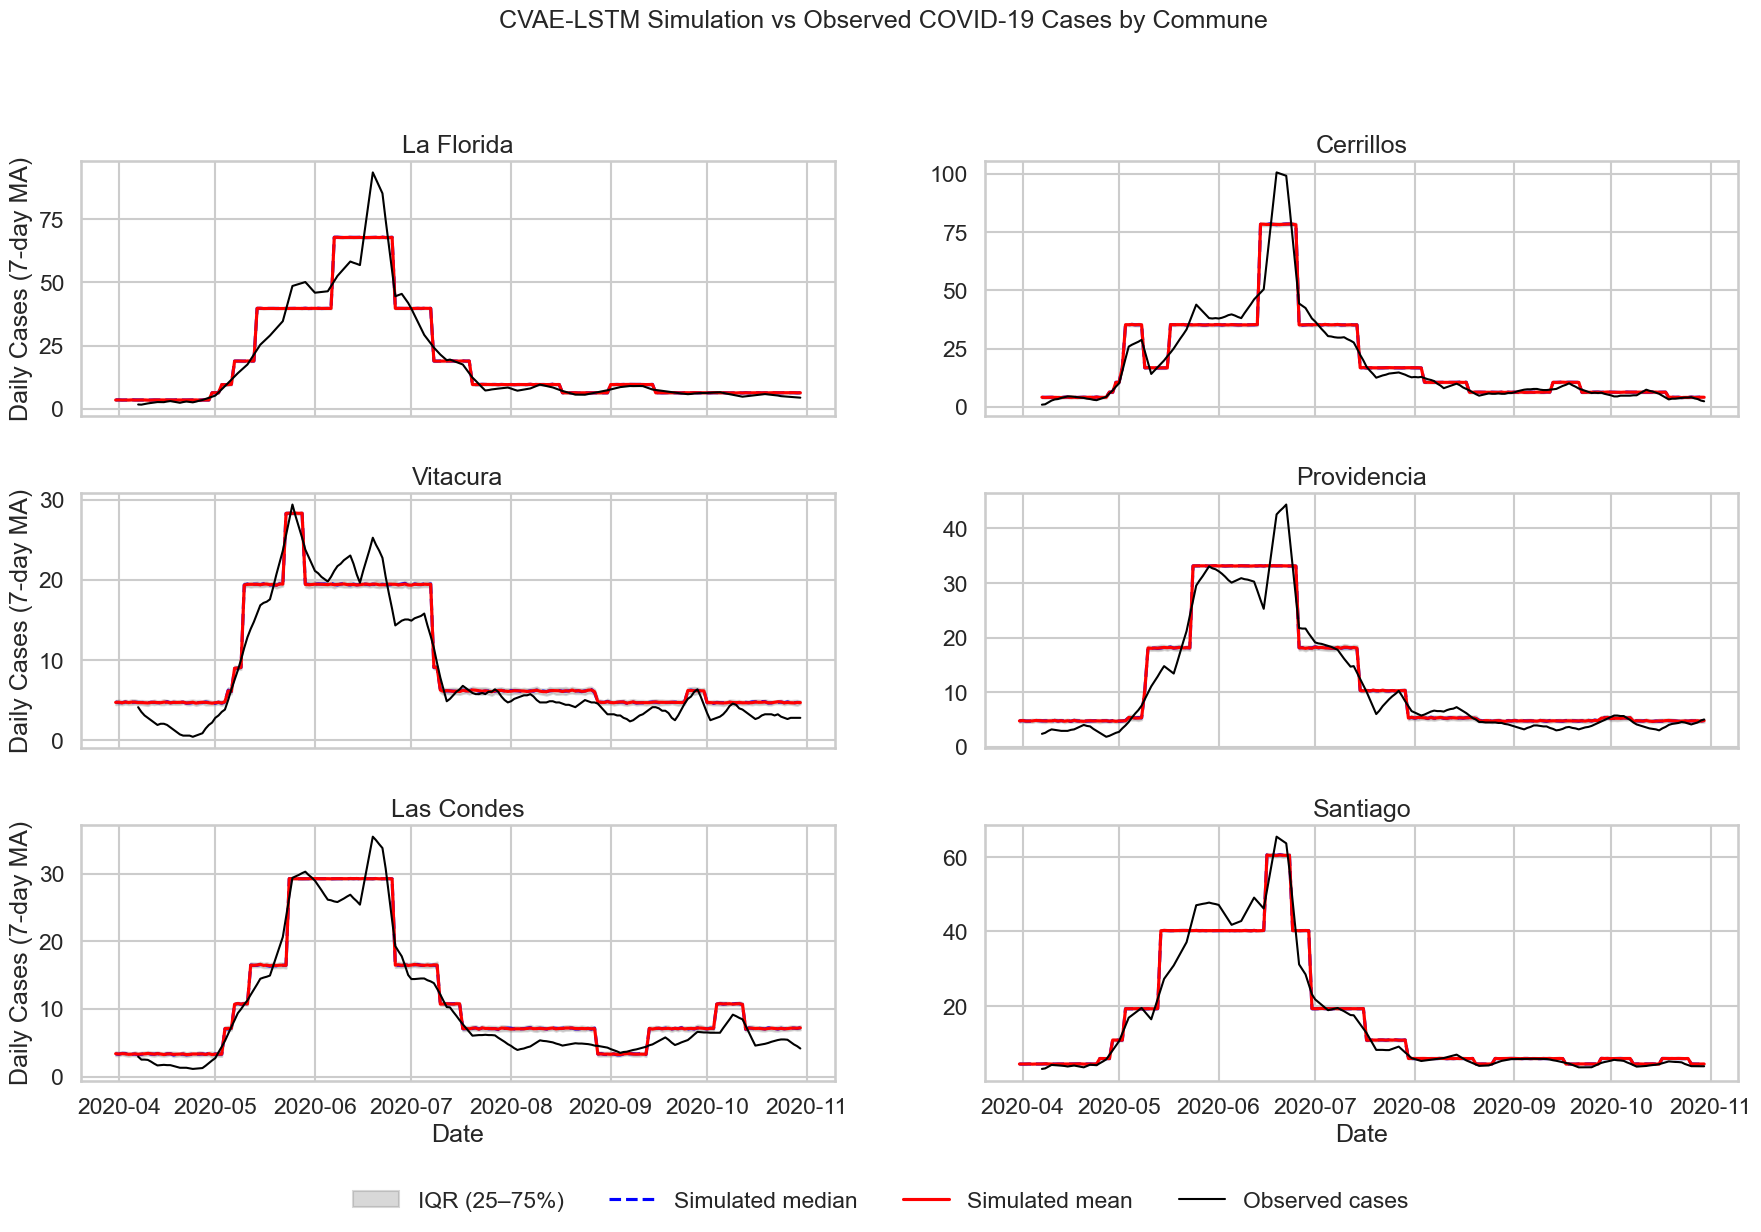

In [18]:
# =========================
# 2. SIMULACIÓN + VISUALIZACIÓN
# =========================
import seaborn as sns
import matplotlib.pyplot as plt

# Usamos solo las comunas target
target_communes = ["La Florida", "Cerrillos", "Vitacura", "Providencia", "Las Condes", "Santiago"]
covid_data = pd.read_csv(data_path, parse_dates=["Date"])
covid_data = covid_data[covid_data["Commune"].isin(target_communes)]

x_raw = covid_data[features].values
x_scaled = scaler.transform(x_raw)

cond_com = enc_com.transform(covid_data[["Commune"]])
cond_st = enc_st.transform(covid_data[["Hidden_State"]])
condition = np.concatenate([cond_com, cond_st], axis=1)

X_seq, C_seq, _ = create_sequences(x_scaled, condition)

# Simulación
model.eval()
sim_results = []
with torch.no_grad():
    for _ in range(100):
        z = torch.randn(len(C_seq), latent_dim)
        cond_tensor = torch.tensor(C_seq, dtype=torch.float32)
        simulated = model.decode(z, cond_tensor).numpy()
        cases_sim = scaler.inverse_transform(simulated)[:, 0]
        sim_results.append(cases_sim)

# Crear DataFrame
sim_df = pd.DataFrame(sim_results).T
sim_df.columns = [f"sim_{i+1}" for i in range(sim_df.shape[1])]
meta = covid_data.iloc[7:].reset_index(drop=True)[:sim_df.shape[0]]
sim_df["Date"] = meta["Date"]
sim_df["Commune"] = meta["Commune"]

# Guardar simulaciones
output_file = os.path.join(l, "simulated_cases_from_cvae_lstm_weighted.csv")
sim_df.to_csv(output_file, index=False)
print(f"✔️ Simulaciones guardadas en: {output_file}")

# Visualización
sim_long = sim_df.melt(id_vars=["Date", "Commune"], var_name="Simulation", value_name="Sim_Cases")
real_df = covid_data.copy()

sns.set(style="whitegrid", context="talk")
fig, axes = plt.subplots(3, 2, figsize=(18, 12), sharex=True)
axes = axes.flatten()

for idx, comuna in enumerate(target_communes):
    ax = axes[idx]
    sim_data = sim_long[sim_long["Commune"] == comuna]
    real_data = real_df[real_df["Commune"] == comuna].iloc[7:7+len(sim_data.groupby("Date"))]

    grouped = sim_data.groupby("Date")["Sim_Cases"]
    p25 = grouped.quantile(0.25)
    p75 = grouped.quantile(0.75)
    p50 = grouped.quantile(0.50)
    mean = grouped.mean()

    ax.fill_between(p25.index, p25, p75, color='gray', alpha=0.3, label="IQR (25–75%)")
    ax.plot(p50.index, p50, linestyle='--', color='blue', label='Simulated median')
    ax.plot(mean.index, mean, linestyle='-', color='red', label='Simulated mean')
    ax.plot(real_data["Date"].values,
            real_data["Gross_Daily_Cases_Mobile_Average_7_Days"].values,
            color='black', linewidth=1.5, label='Observed cases')
    ax.set_title(comuna)
    if idx % 2 == 0:
        ax.set_ylabel("Daily Cases (7-day MA)")
    if idx >= 4:
        ax.set_xlabel("Date")

fig.legend(*axes[0].get_legend_handles_labels(), loc='lower center', ncol=4, frameon=False)
fig.suptitle("CVAE-LSTM Simulation vs Observed COVID-19 Cases by Commune", fontsize=18, y=1.02)
fig.tight_layout(rect=[0, 0.05, 1, 0.98])
fig.subplots_adjust(hspace=0.3, wspace=0.2)
fig.savefig(os.path.join(l, "cvae_lstm_weighted_sim_vs_real.png"), dpi=600)
fig.savefig(os.path.join(l, "cvae_lstm_weighted_sim_vs_real.pdf"), dpi=600)
plt.show()


### Mejorando la visualización

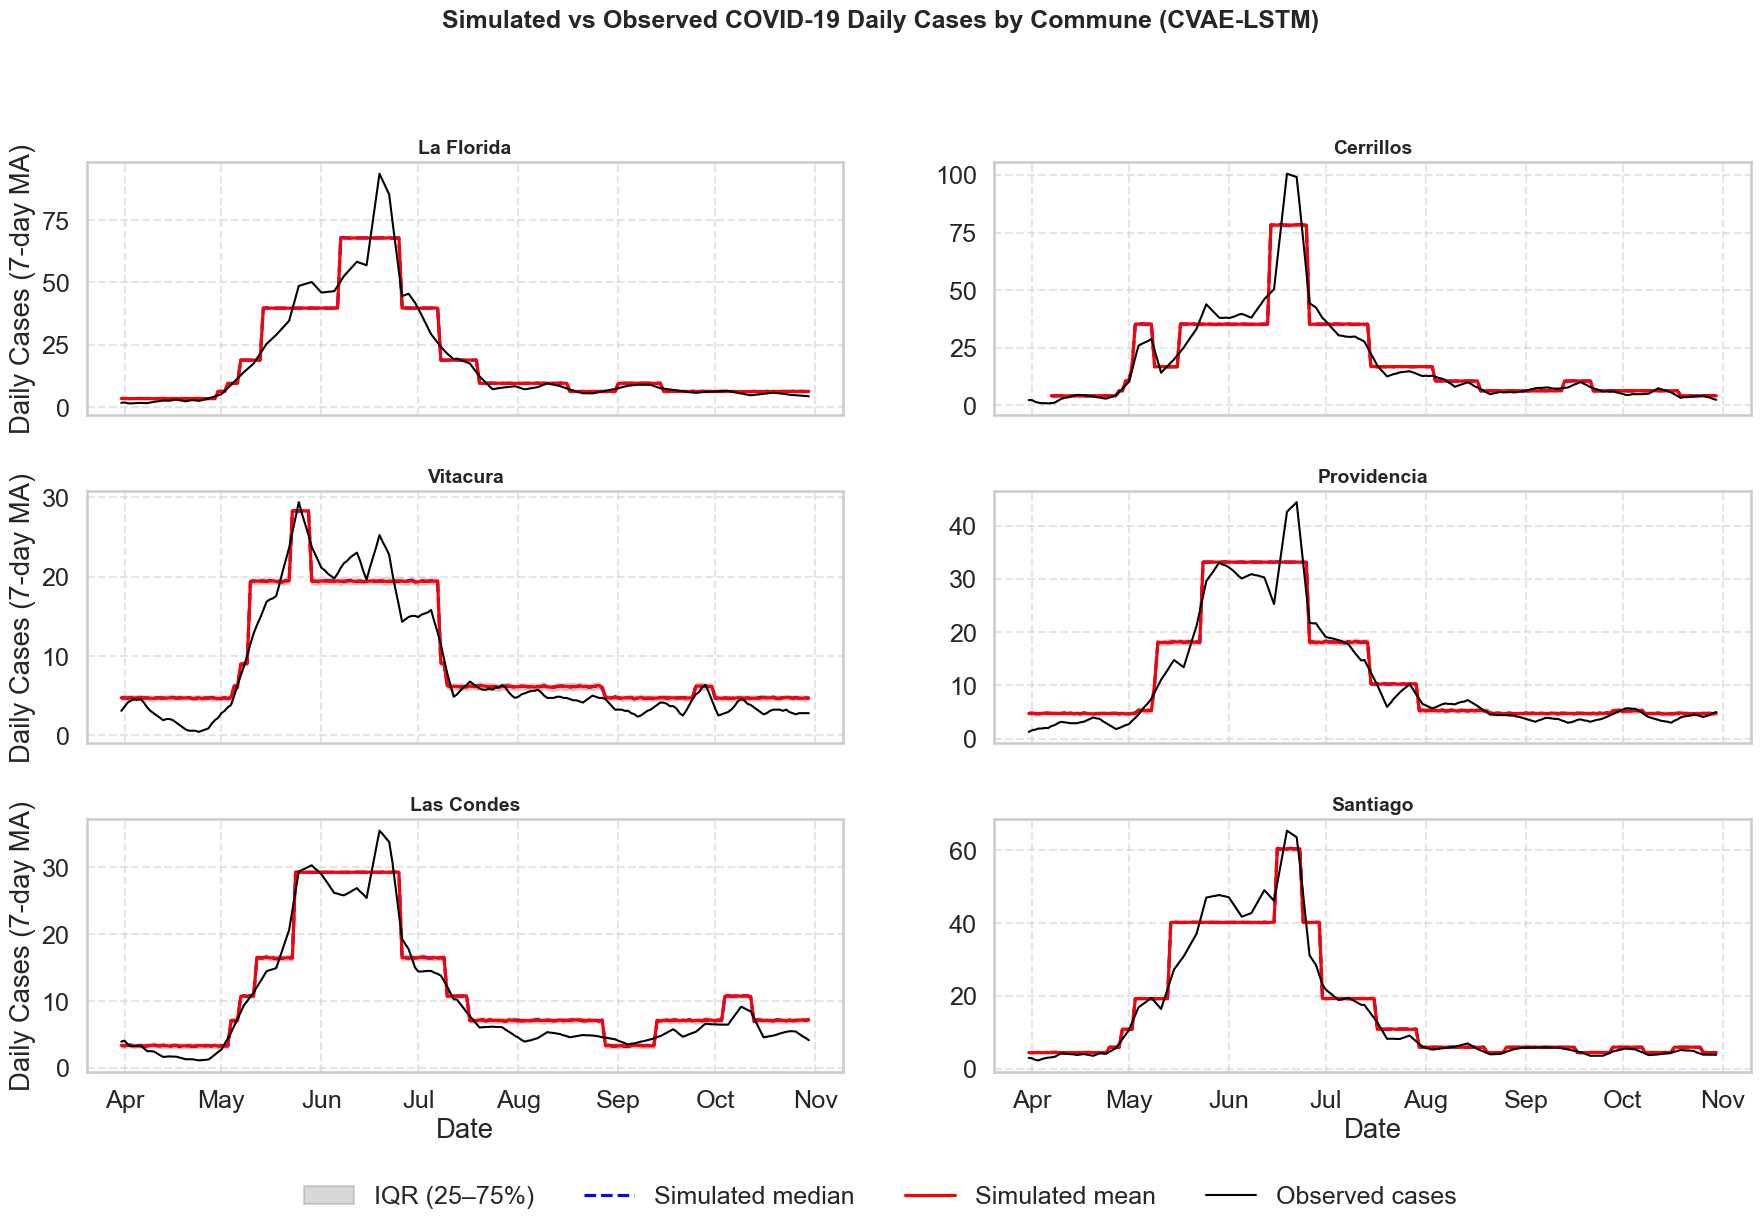

In [21]:
# =====================================
# CVAE-LSTM Simulation: Final Plot Code
# =====================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import os

# Path to data
l = '/Users/mauricioherrera/mis_env/covid-nhmm/notebooks'
sim_path = os.path.join(l, "simulated_cases_from_cvae_lstm_weighted.csv")
real_path = os.path.join(l, "covid_data_with_6_states.csv")

# Load simulation and real data
sim_df = pd.read_csv(sim_path, parse_dates=["Date"])
real_df = pd.read_csv(real_path, parse_dates=["Date"])

# Target communes
target_communes = ["La Florida", "Cerrillos", "Vitacura", "Providencia", "Las Condes", "Santiago"]
sim_df = sim_df[sim_df["Commune"].isin(target_communes)]
real_df = real_df[real_df["Commune"].isin(target_communes)]

# Reshape simulation dataframe
sim_cols = [col for col in sim_df.columns if col.startswith("sim_") or col.startswith("X")]
sim_long = sim_df.melt(id_vars=["Date", "Commune"], value_vars=sim_cols,
                       var_name="Simulation", value_name="Sim_Cases")

# Plot aesthetics
sns.set(style="whitegrid", context="talk", font_scale=1.1)
fig, axes = plt.subplots(3, 2, figsize=(18, 12), sharex=True)
axes = axes.flatten()

for idx, commune in enumerate(target_communes):
    ax = axes[idx]
    sim_data = sim_long[sim_long["Commune"] == commune]
    real_data = real_df[real_df["Commune"] == commune].copy()

    grouped = sim_data.groupby("Date")["Sim_Cases"]
    p25 = grouped.quantile(0.25)
    p75 = grouped.quantile(0.75)
    p50 = grouped.quantile(0.50)
    mean = grouped.mean()

    # Plot uncertainty band
    ax.fill_between(p25.index, p25, p75, color='gray', alpha=0.3, label="IQR (25–75%)")

    # Simulated trajectories
    ax.plot(p50.index, p50, linestyle='--', color='blue', label='Simulated median')
    ax.plot(mean.index, mean, linestyle='-', color='red', label='Simulated mean')

    # Real data
    ax.plot(real_data["Date"], real_data["Gross_Daily_Cases_Mobile_Average_7_Days"],
            color='black', linewidth=1.5, label='Observed cases')

    # Labels and formatting
    ax.set_title(commune, fontsize=14, weight='bold')
    ax.grid(True, linestyle='--', alpha=0.5)

    # X and Y axes
    if idx % 2 == 0:
        ax.set_ylabel("Daily Cases (7-day MA)")
    if idx >= 4:
        ax.set_xlabel("Date")

    # Format x-axis with month abbreviations
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# Legend and layout
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4, frameon=False, fontsize=18)

fig.suptitle("Simulated vs Observed COVID-19 Daily Cases by Commune (CVAE-LSTM)", 
             fontsize=18, weight='bold', y=1.02)
fig.tight_layout(rect=[0, 0.05, 1, 0.98])
fig.subplots_adjust(hspace=0.3, wspace=0.2)

# Save output
fig.savefig(os.path.join(l, "cvae_lstm_simulated_vs_real_en.png"), dpi=600)
fig.savefig(os.path.join(l, "cvae_lstm_simulated_vs_real_en.pdf"), dpi=600)

plt.show()
